import urllib.request

url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
week_nums = [190504, 190511, 190518, 190525, 190601, 190608, 190615, 190622, 190629, 190706, 190713, 190720, 190727]

for week_num in week_nums:
    urllib.request.urlretrieve(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week_num}.txt",
                               f"data/turnstile_{week_num}.txt")

In [4]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

engine = create_engine("sqlite:///mta.db")
all_data = pd.read_sql('SELECT * FROM mta_data;', engine)

In [5]:
%config InlineBackend.figure_format = 'png'
%matplotlib inline 

In [10]:
df = all_data

In [11]:
# Need to change columns to row-index 0
#df.rename(columns = df.loc[0], inplace =True)

# Remove row 0
#df = df.drop([0], inplace=True)

#Drop dups
#df.drop_duplicates(inplace=True)


KeyError: 0

In [13]:
# Need to convert EXITS column field11 into numeric type
df['EXITS'] = df['EXITS'].astype(np.float64)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2684040 entries, 1 to 2684040
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   C/A       object 
 1   UNIT      object 
 2   SCP       object 
 3   STATION   object 
 4   LINENAME  object 
 5   DIVISION  object 
 6   DATE      object 
 7   TIME      object 
 8   DESC      object 
 9   ENTRIES   object 
 10  EXITS     float64
dtypes: float64(1), object(10)
memory usage: 245.7+ MB


In [15]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
1,A002,R051,02-00-00,59 ST-BMT,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,0007035249,2384833.0
2,A002,R051,02-00-00,59 ST-BMT,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,0007035269,2384840.0
3,A002,R051,02-00-00,59 ST-BMT,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,0007035292,2384875.0
4,A002,R051,02-00-00,59 ST-BMT,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,0007035392,2384951.0
5,A002,R051,02-00-00,59 ST-BMT,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,0007035651,2385020.0


In [16]:
# Need to find the max(EXITS) for each (SCP) by DATE
#This excludes the EXITS count from TIME 20:00-23:59 each day. The data from this date frame is not as relevant to my company of interest.
#The EXITS count during this time is likely minimal. Additionally, scooters are reclaimed at night to charge to be redeployed the next morning.
#I used .shift method with PREV_EXITS initially. However, for C/A==S101A, SCP==01-00-03 between 05/01/2019 and 05/02/2019 there was an unexplained jump from 432 to 1078346838.
max_exit = df.groupby(['C/A','SCP','STATION','DATE'])[['EXITS']].max()

In [17]:
# Need to find the min(EXITS) for each (SCP) by DATE
min_exit = df.groupby(['C/A','SCP','STATION','DATE'])[['EXITS']].min()

In [18]:
#Merging total scp exits data into one df, on matching SCP column
total_scp_exit = pd.merge(max_exit, min_exit, on=['C/A','SCP','STATION','DATE'])
total_scp_exit.head()

EXITS_x    EXITS_y
C/A  SCP      STATION   DATE                            
A002 02-00-00 59 ST-BMT 04/27/2019  2385070.0  2384833.0
                        04/28/2019  2385240.0  2385087.0
                        04/29/2019  2385732.0  2385256.0
                        04/30/2019  2386197.0  2385765.0
                        05/01/2019  2386673.0  2386229.0

In [19]:
# total_scp_exits = max-min for each turnstile SCP per DATE
total_scp_exit['exits_per_day'] = total_scp_exit['EXITS_x']-total_scp_exit['EXITS_y']
total_scp_exit.head()

EXITS_x    EXITS_y  exits_per_day
C/A  SCP      STATION   DATE                                           
A002 02-00-00 59 ST-BMT 04/27/2019  2385070.0  2384833.0          237.0
                        04/28/2019  2385240.0  2385087.0          153.0
                        04/29/2019  2385732.0  2385256.0          476.0
                        04/30/2019  2386197.0  2385765.0          432.0
                        05/01/2019  2386673.0  2386229.0          444.0

In [20]:
#There are some large inexplicable jumps in the EXITS count
total_scp_exit.sort_values(['exits_per_day'], ascending=False)

EXITS_x      EXITS_y  \
C/A   SCP      STATION       DATE                                    
C008  00-00-00 DEKALB AV     07/26/2019  1.850345e+09    8702864.0   
N207  00-00-00 167 ST        06/14/2019  1.828766e+09    7175686.0   
R401  00-00-00 3 AV 138 ST   07/14/2019  1.426011e+09   11255249.0   
R258  00-06-00 125 ST        07/04/2019  1.409339e+09    5560810.0   
R311  00-00-00 3 AV-149 ST   06/19/2019  1.476891e+09  123244243.0   
...                                               ...          ...   
H032  00-05-00 WILSON AV     05/25/2019  0.000000e+00          0.0   
                             05/24/2019  0.000000e+00          0.0   
                             05/23/2019  0.000000e+00          0.0   
                             05/22/2019  0.000000e+00          0.0   
TRAM2 00-05-01 RIT-ROOSEVELT 07/26/2019  3.830000e+02        383.0   

                                         exits_per_day  
C/A   SCP      STATION       DATE                       
C008  00-00-00 DEKALB AV     07/26/2019   1.841642e+09  
N207  00-00-00 167 ST        06/14/2019   1.821591e+09  
R401  00-00-00 3 AV 138 ST   07/14/2019   1.414756e+09  
R258  00-06-00 125 ST        07/04/2019   1.403778e+09  
R311  00-00-00 3 AV-149 ST   06/19/2019   1.353647e+09  
...                                                ...  
H032  00-05-00 WILSON AV     05/25/2019   0.000000e+00  
                             05/24/2019   0.000000e+00  
                             05/23/2019   0.000000e+00  
                             05/22/2019   0.000000e+00  
TRAM2 00-05-01 RIT-ROOSEVELT 07/26/2019   0.000000e+00  

[441890 rows x 3 columns]

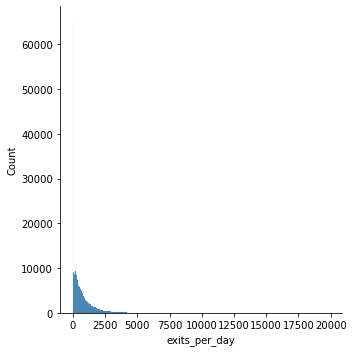

In [21]:
sns.displot(total_scp_exit[(total_scp_exit.exits_per_day <20000)].exits_per_day)
#This shows distribution of exits_per_day values

In [22]:
#Remove exits_per_day values > 20000
total_scp_exit2 = total_scp_exit[(total_scp_exit.exits_per_day <20000)]

In [23]:
#Find AVG EXITS per day per SCP.
avg_daily_exit = total_scp_exit2.groupby(['C/A','STATION','SCP'])[['exits_per_day']].mean()
avg_daily_exit.head()

exits_per_day
C/A  STATION   SCP                    
A002 59 ST-BMT 02-00-00     346.791209
               02-00-01     203.901099
               02-03-00    1485.406593
               02-03-01    1522.923077
               02-03-02    1157.890110

In [24]:
#Group by C/A and return the mean of daily exits of all SCP per C/A
station_daily = avg_daily_exit.groupby(['C/A','STATION'])[['exits_per_day']].mean()
station_daily.head(10)

,,exits_per_day
C/A,STATION,
A002,59 ST-BMT,523.565934
A006,5 AV/59 ST,871.822802
A007,5 AV/59 ST,530.265690
A010,57 ST-7 AV,768.451923
A011,57 ST-7 AV,2987.151648
A013,49 ST,894.094017
A015,49 ST,702.142857
A016,49 ST,455.487912
A021,TIMES SQ-42 ST,2150.969780


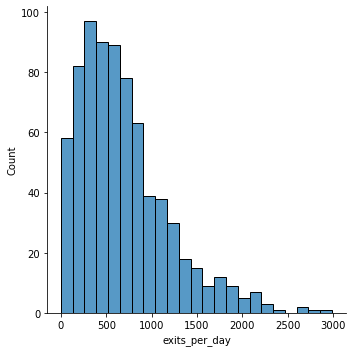

In [25]:
sns.displot(station_daily.exits_per_day)

In [37]:
#Sorting DESC to find top 5 stations
station_daily = station_daily.sort_values(by=['exits_per_day'],ascending=False).round(decimals=2)
station_daily.head(10)

,,exits_per_day
C/A,STATION,
A011,57 ST-7 AV,2987.15
R216,SPRING ST,2785.67
R238,GRD CNTRL-42 ST,2667.11
R135,34 ST-PENN STA,2650.36
N100,HIGH ST,2447.81
R249,86 ST,2325.07
A025,34 ST-HERALD SQ,2262.11
A033,14 ST-UNION SQ,2237.28
R161A,72 ST,2199.00


In [50]:
station_daily.reset_index(inplace=True)

In [53]:
station_daily=station_daily.head(10)

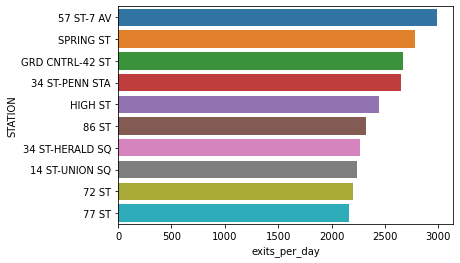

In [56]:
top_10 = sns.barplot(data=station_daily, x='exits_per_day', y='STATION').figure.savefig("Top10.png")

SELECT * FROM mta_data m
LEFT JOIN neighborhoods n ON m.field4 = n.field1
#----
UPDATE mta_data
SET field4 ='PARK PLACE-IRT'
WHERE field4 ='PARK PLACE' AND field6 ='IRT'
#----
UPDATE mta_data
SET field4 ='PARK PLACE-BMT'
WHERE field4 ='PARK PLACE' AND field6 ='BMT' 
#----
UPDATE mta_data
SET field4 ='BROADWAY-BMT'
WHERE field4 ='BROADWAY' AND field6='BMT'
#----  
UPDATE mta_data    
SET field4 ='BROADWAY-IND'
WHERE field4 ='BROADWAY' AND field6='IND'
#----
UPDATE mta_data
SET field4 ='59 ST-IRT'
WHERE field4 ='59 ST' AND field6='IRT'
#----
UPDATE mta_data
SET field4 ='59 ST-BMT'
WHERE field4 ='59 ST' AND field6='BMT'
#
UPDATE mta_data
SET field4 ='7 AV-BKN'
WHERE field4 ='7 AV' AND field5='BDE' OR field5='BQ'